In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, VARIABLES_PATTERN, K, N, P

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2024-12-31 11:41:28,140 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
2024-12-31 11:41:28,140 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
2024-12-31 11:41:28,141 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


In [2]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)

[    0    10    22 ... 99922 99956 99992]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


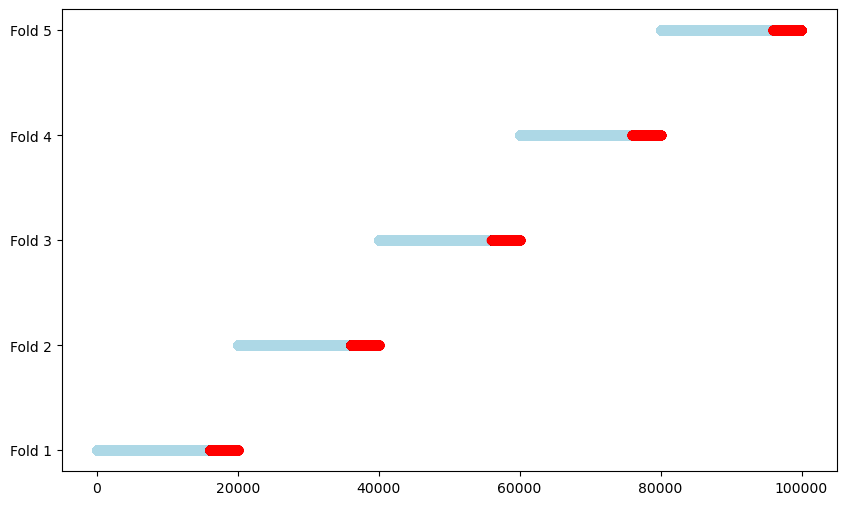

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19979, 100, 3])
X_mask shape: torch.Size([19979, 100])
X_indices shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


Number of finished trials:  100
Best trial: 97
Best hyperparameters: {'learning_rate': 0.0007549890984756428, 'num_layers': 3, 'kernel_size': 7, 'pool_size': 3, 'batch_size': 32, 'num_filters_layer_0': 16, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64}
Validation Losses: [70.329, 62.288, 58.485, 78.925, 68.685]
Mean validation loss: 67.742
Test Losses: [74.994, 72.714, 58.918, 84.771, 76.977]
Mean test loss: 73.675
Mean test MAE: 6.418 std: 0.392
Mean test RMSE: 8.569 std: 0.501


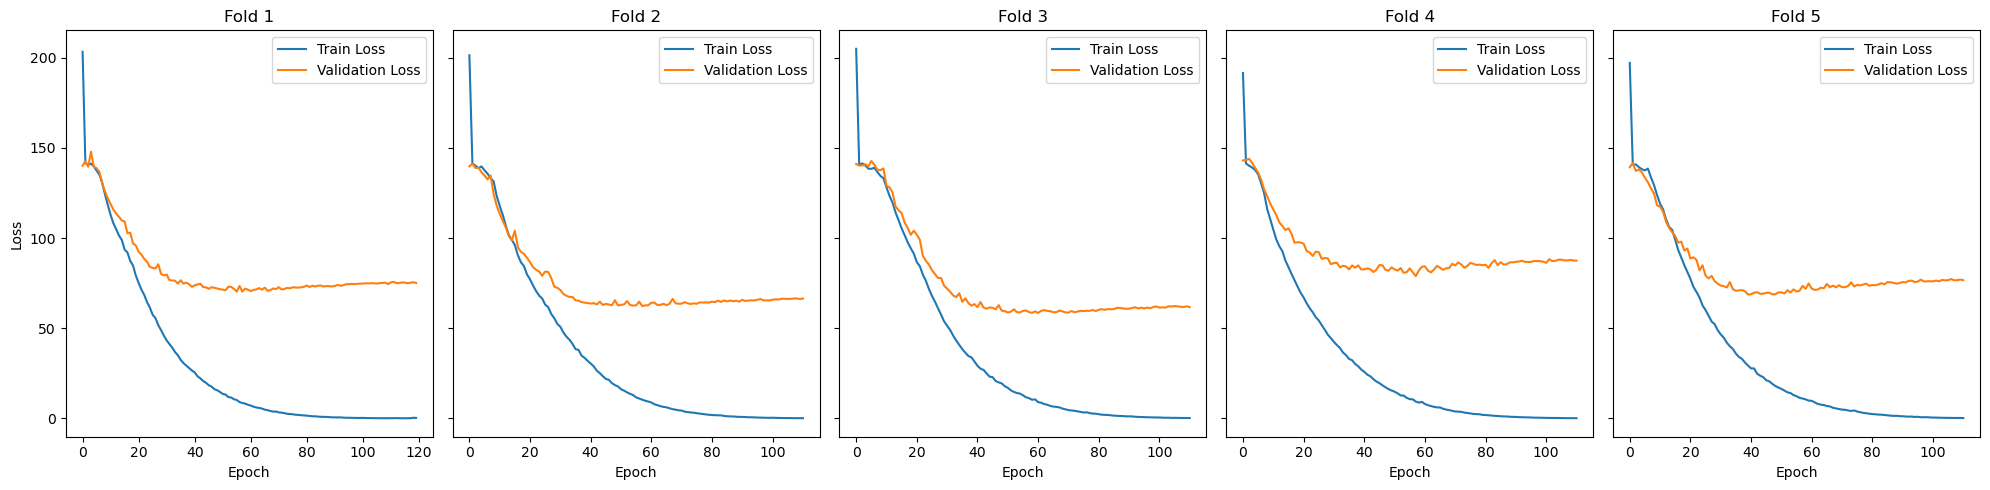

In [6]:
from models.cnn_pytorch import CNN
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None, 2, 3]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed, [X_series], y, [True], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

Best hyperparameters: {'learning_rate': 0.0007549890984756428, 'num_layers': 3, 'kernel_size': 7, 'pool_size': 3, 'batch_size': 32, 'num_filters_layer_0': 16, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64}
Early stopping at epoch 120, with best epoch being 55
Early stopping at epoch 111, with best epoch being 57
Early stopping at epoch 111, with best epoch being 60
Early stopping at epoch 111, with best epoch being 57
Early stopping at epoch 111, with best epoch being 39
Validation Losses: [70.32869720458984, 62.28826904296875, 58.484779357910156, 78.92507934570312, 68.68511199951172]
Mean validation loss: 67.74238739013671
Test Losses: [74.99431610107422, 72.71412658691406, 58.918190002441406, 84.7706527709961, 76.97710418701172]
Mean test loss: 73.6748779296875


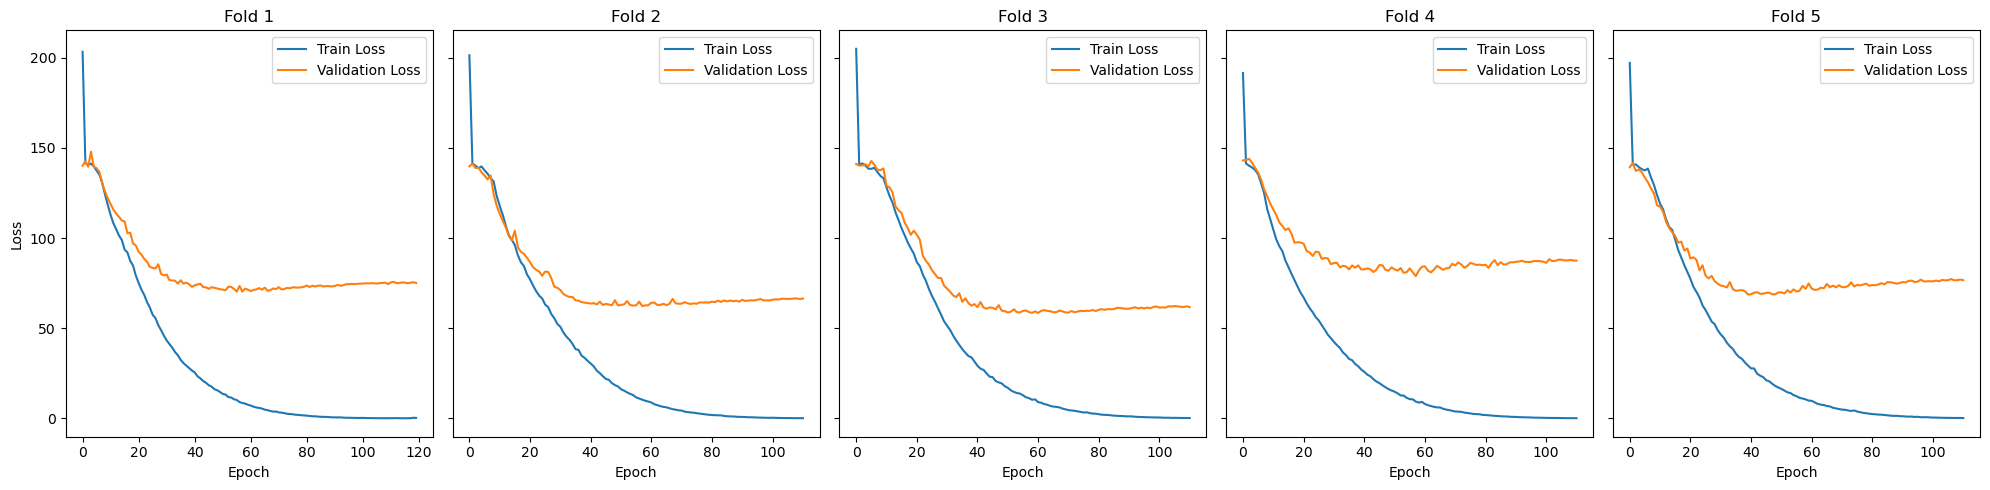

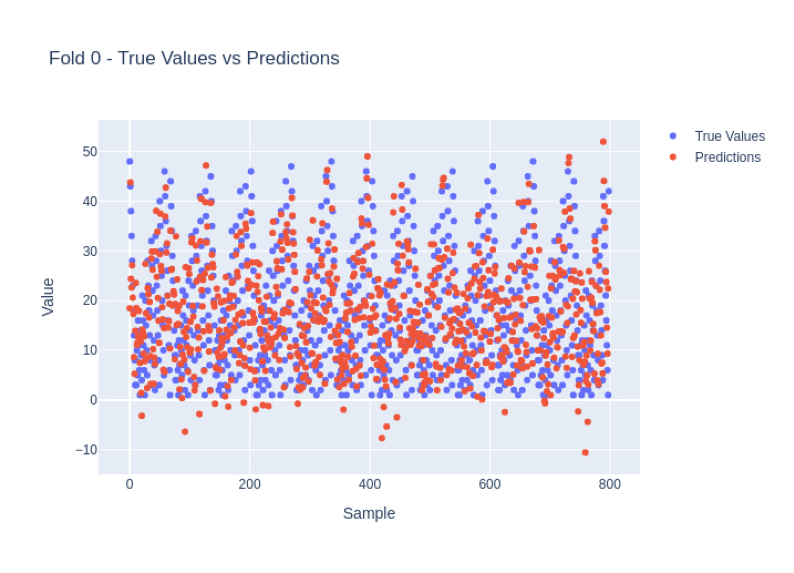

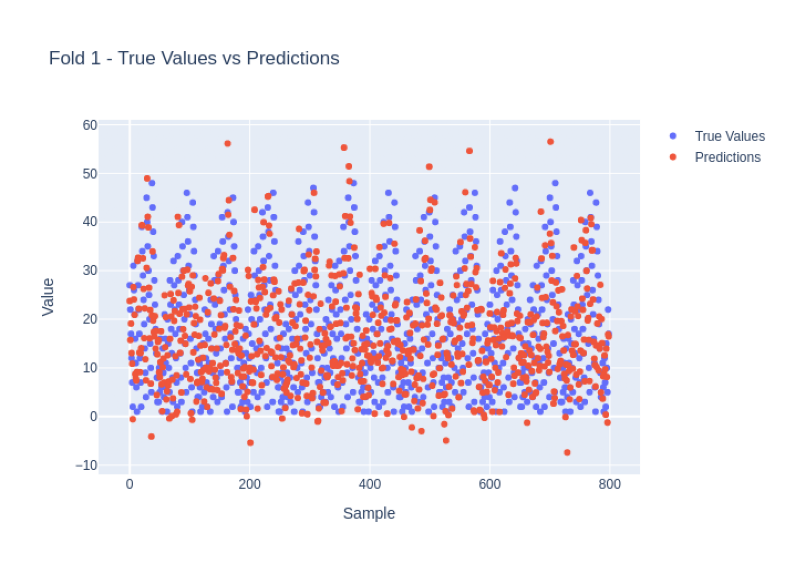

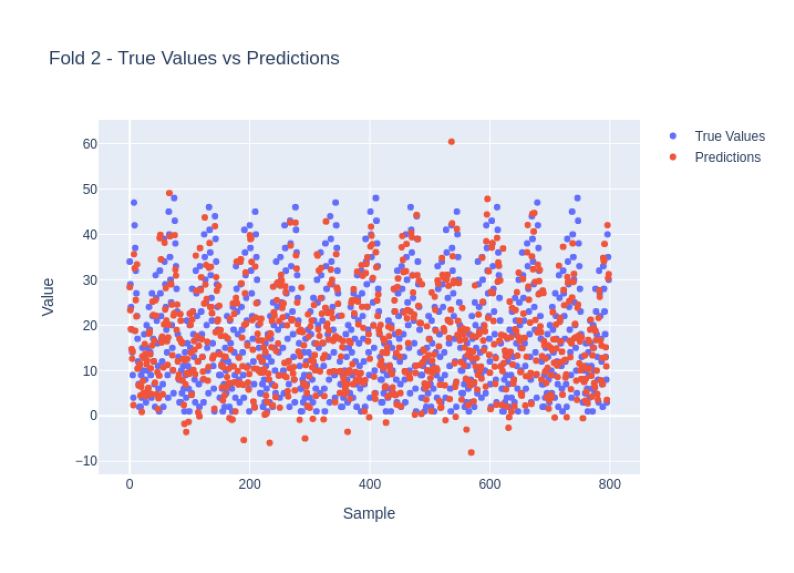

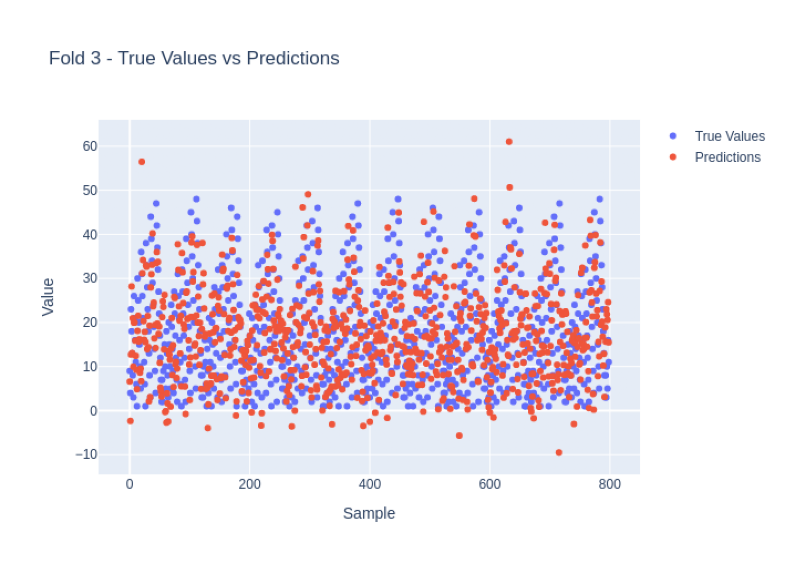

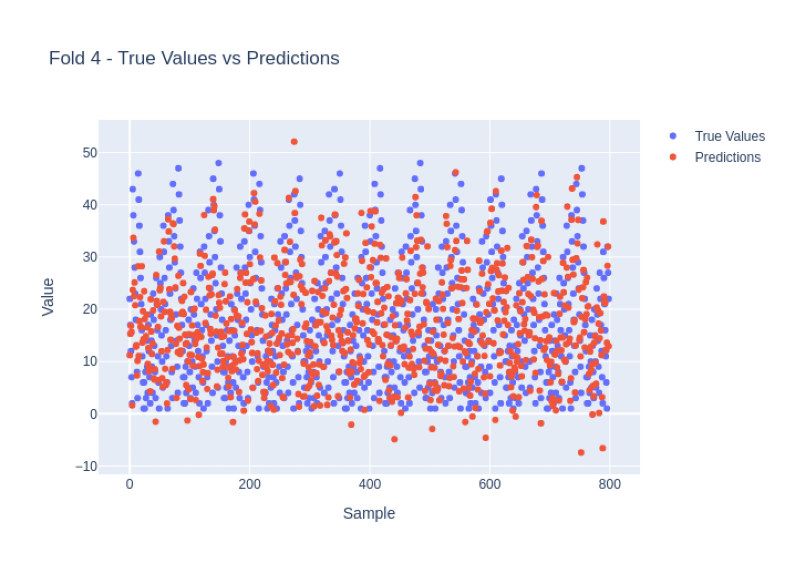

In [7]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series], y=y, normalize_flags=[True])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()

Number of finished trials:  100
Best trial: 71
Best hyperparameters: {'learning_rate': 0.00029092761865418177, 'num_layers': 3, 'kernel_size': 7, 'pool_size': 3, 'batch_size': 64, 'num_filters_layer_0': 32, 'num_filters_layer_1': 32, 'num_filters_layer_2': 64}
Validation Losses: [0.871, 0.884, 0.854, 0.506, 1.179]
Mean validation loss: 0.859
Test Losses: [1.077, 1.115, 0.836, 0.556, 1.178]
Mean test loss: 0.953
Mean test MAE: 0.701 std: 0.085
Mean test RMSE: 0.968 std: 0.125


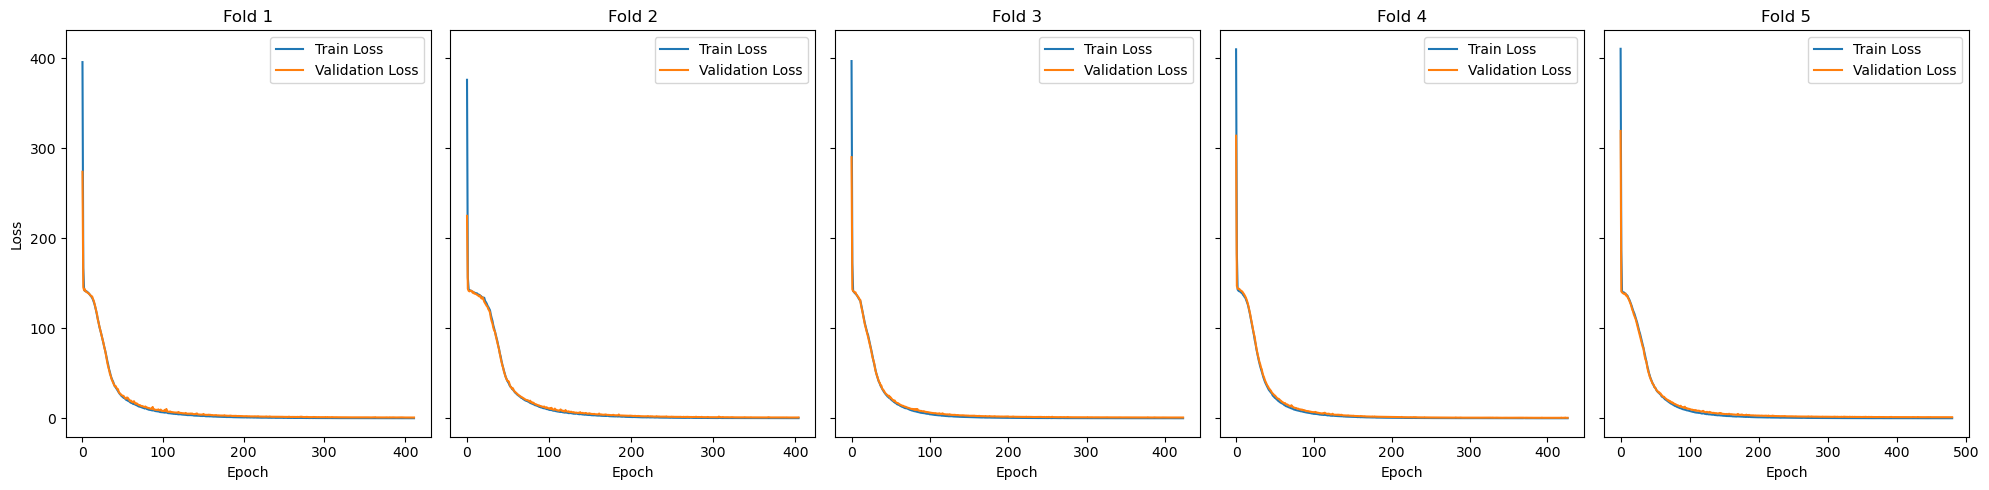

In [8]:
from models.cnn_pytorch import CNN
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None, 2, 3]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}


model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed, X1, X_mask, y, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



Best hyperparameters: {'learning_rate': 0.00029092761865418177, 'num_layers': 3, 'kernel_size': 7, 'pool_size': 3, 'batch_size': 64, 'num_filters_layer_0': 32, 'num_filters_layer_1': 32, 'num_filters_layer_2': 64}


Early stopping at epoch 412, with best epoch being 401
Early stopping at epoch 405, with best epoch being 394
Early stopping at epoch 424, with best epoch being 413
Early stopping at epoch 427, with best epoch being 416
Early stopping at epoch 481, with best epoch being 470
Validation Losses: [0.8709325790405273, 0.883821427822113, 0.8541153073310852, 0.5062159895896912, 1.1792386770248413]
Mean validation loss: 0.8588647961616516
Test Losses: [1.0767483711242676, 1.1154805421829224, 0.8360576033592224, 0.5562689900398254, 1.1782443523406982]
Mean test loss: 0.9525599718093872


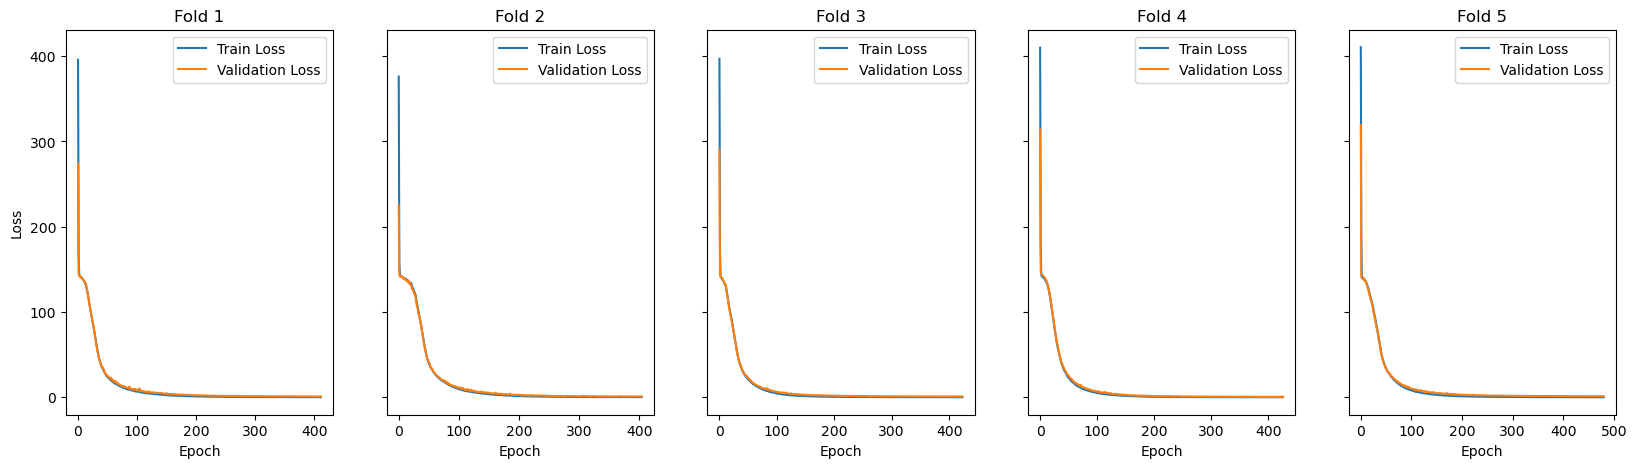

In [10]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series, X_mask], y=y, normalize_flags=[True,False])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 44
Best hyperparameters: {'learning_rate': 0.0008564356308349053, 'num_layers': 4, 'kernel_size': 7, 'pool_size': None, 'batch_size': 32, 'num_filters_layer_0': 64, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64, 'num_filters_layer_3': 64}
Validation Losses: [0.042, 0.027, 0.03, 0.009, 0.004]
Mean validation loss: 0.023
Test Losses: [0.202, 0.503, 0.296, 0.013, 0.924]
Mean test loss: 0.388
Mean test MAE: 0.345 std: 0.172
Mean test RMSE: 0.555 std: 0.281


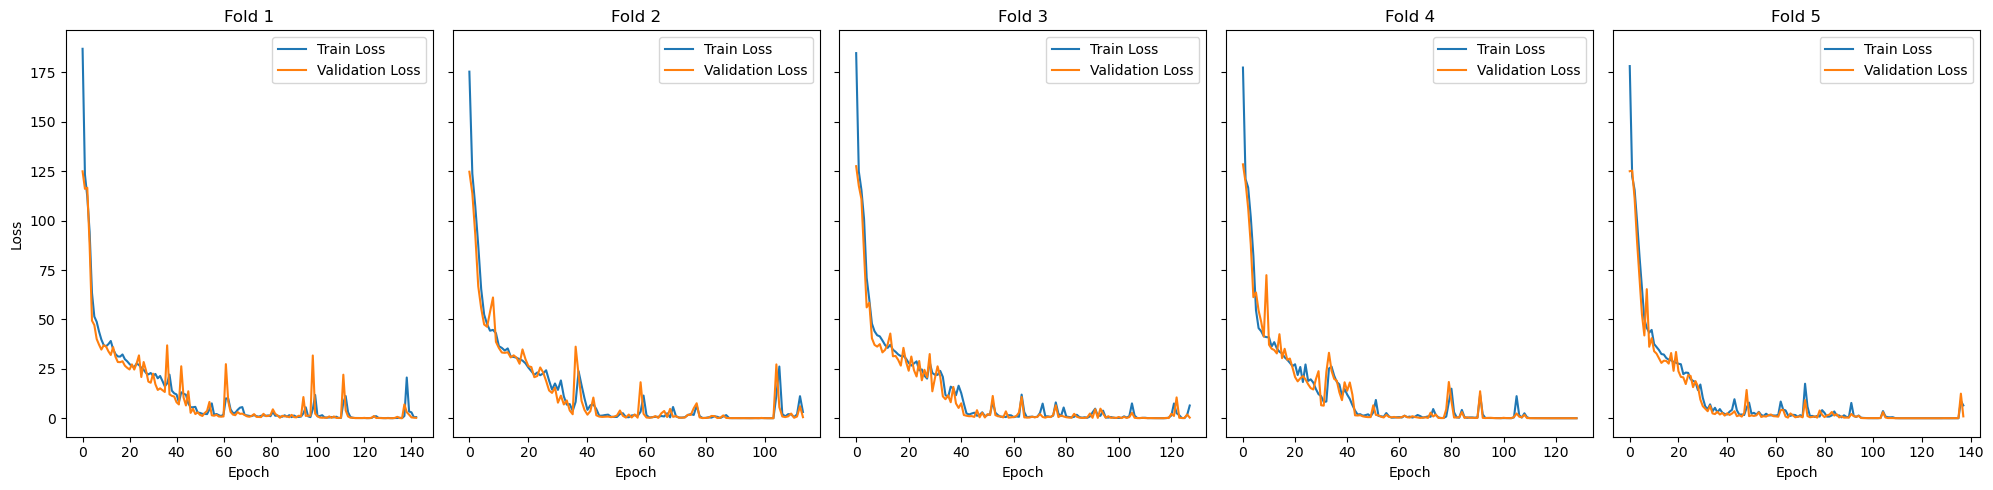

In [6]:
from models.cnn_pytorch import CNN
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNIndexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed,[X_indices], y, [True], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)


Best hyperparameters: {'learning_rate': 0.0008564356308349053, 'num_layers': 4, 'kernel_size': 7, 'pool_size': None, 'batch_size': 32, 'num_filters_layer_0': 64, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64, 'num_filters_layer_3': 64}
Early stopping at epoch 143, with best epoch being 132
Early stopping at epoch 114, with best epoch being 103
Early stopping at epoch 128, with best epoch being 117
Early stopping at epoch 129, with best epoch being 118
Early stopping at epoch 138, with best epoch being 127
Validation Losses: [0.04246331378817558, 0.0273575522005558, 0.030307967215776443, 0.008885862305760384, 0.004290653392672539]
Mean validation loss: 0.02266106978058815
Test Losses: [0.20166489481925964, 0.5031546354293823, 0.29586145281791687, 0.012719734571874142, 0.9244596362113953]
Mean test loss: 0.38757207076996564


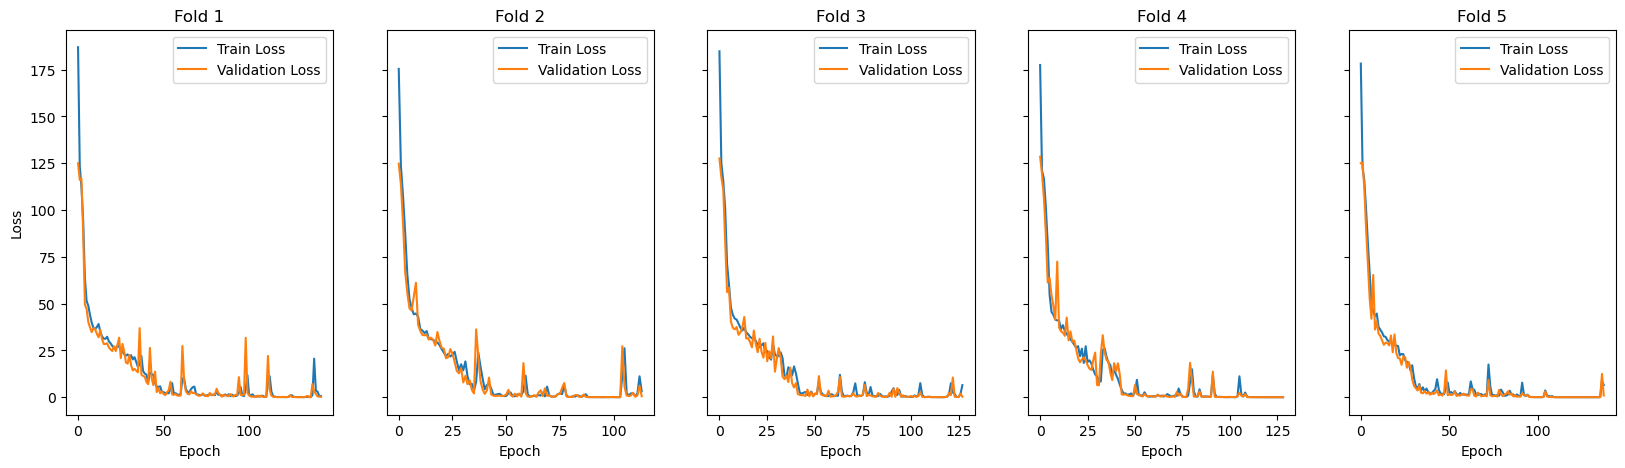

In [7]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_indices], y=y, normalize_flags=[True])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# # for fold in range(5):
# #     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()
